# Overview figure + Fan shaped body figure

Here's where I'll keep the code which produces the figures for the paper, which may end up very involved as I tweak little things

* [**Figure 1**](#Figure-1)
    * [**Brain Regions**](#Brain-Regions)
    * [**Shaded Meshes**](#Shaded-meshes)

In [2]:
import os
import time
import pandas as pd
import numpy as np
import networkx as nx
import dotmotif
import collections
from scipy import sparse as sp
from scipy.stats import rankdata

from itertools import combinations, combinations_with_replacement, cycle
from functools import reduce

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["font.sans-serif"] = "Helvetica"


import bokeh
from bokeh.io import output_notebook, output_file, show, save
from bokeh.plotting import figure
from bokeh.models import (Rect, MultiLine, Circle, Span, Label,
                          GraphRenderer, StaticLayoutProvider,
                          NodesAndLinkedEdges,
                          HoverTool, TapTool, ColumnDataSource,
                          LinearColorMapper, LogColorMapper, CategoricalColorMapper,
                          CategoricalMarkerMapper,
                          BoxSelectTool,
                          ColorBar, BasicTicker, BoxZoomTool, FactorRange,
                          Range1d)
from bokeh.models import CategoricalTicker, FixedTicker, BoxAnnotation
from bokeh.models import Arrow, NormalHead, OpenHead, VeeHead, LabelSet

from bokeh.transform import transform, factor_cmap, linear_cmap, log_cmap
from bokeh.layouts import row, column, gridplot
output_notebook()

import ipyvolume as ipv

import colorcet as cc


from visualization.vis import *
from visualization.vis3d import *
# from visualization.vis import (draw_graph,
#                                circle_layout_graph, breakdown_flowchart_graph,
#                                breakdown_barchart_figure, code_heatmap,
#                                display_dataframe, roi_adj_fig,
#                                tuple_to_string, repeat_to_match_lengths,
#                                poincare_geodesic, outer_loop_circle,
#                                normalize)
from visualization.reduce_graphs import reduced_graph, cluster_codes, subgraph
# from util import log_msg, simplify_type
from util import *

from math import pi

log_msg("Imports complete")

Loading BokehJS ...

2022 11 15 10:26:22  Imports complete


In [3]:
hemibrain_version = "v1.1"
log_msg("Hemibrain data set being used:", hemibrain_version)

2022 11 15 10:26:22  Hemibrain data set being used: v1.1


In [33]:
preproc_dir = "hemibrain/preprocessed-" + hemibrain_version
preproc_nodes = "preprocessed_nodes.csv"
preproc_centroids = "preprocessed_nodes_with_centroids.csv"
preproc_edges = "preprocessed_undirected_edges.csv"

hemibrain_dir = "hemibrain/exported-traced-adjacencies-" + hemibrain_version
hemibrain_nodes = "traced-neurons.csv"
hemibrain_edges = "traced-total-connections.csv"
hemibrain_roi_edges = "traced-roi-connections.csv"

# figure_dir = os.path.join("figures","paper")
figure_dir = "/Volumes/GoogleDrive/My Drive/fly brain paper/figures/assets"
movie_dir = os.path.join("movies")
analysis_dir = os.path.join("analysis",hemibrain_version)
obj_dir = os.path.join("obj",hemibrain_version)  # 3d objects from, e.g. fetch_roi_mesh
skel_dir = os.path.join("skeleton", hemibrain_version)  # skeleta of neurons in .csv format


for d in [figure_dir, analysis_dir, obj_dir, movie_dir]:
    if not os.path.isdir(d):
        log_msg("Creating directory", d)
        os.makedirs(d)

reneel_params = list(sorted(['0.0', '1.0', '0.5', '0.25', '0.1', '0.05', '0.75'], key=float))
type_params = ['celltype','instance']
list_of_params = reneel_params + type_params

log_msg("Set up directory info and useful lists")

2022 11 15 10:31:55  Set up directory info and useful lists


In [5]:
from neuprint import Client
from neuprint import fetch_roi_hierarchy


auth_token_file = open("flybrain.auth", 'r')
auth_token = next(auth_token_file).strip()
try:
    np_client = Client('neuprint.janelia.org', dataset='hemibrain:' + hemibrain_version, token=auth_token)
    log_msg("neuprint Client set up as `np_Client`, version", np_client.fetch_version())
except:
    np_client = None
    log_msg("neuprint Client set up failed!")

2022 11 15 10:26:24  neuprint Client set up as `np_Client`, version 0.1.0


## Load the node dataframe

In [6]:
log_msg("Loading node dataframe")
if os.path.isfile(os.path.join(preproc_dir, preproc_centroids)):
    log_msg("  (with centroids)")
    HB_node_df = pd.read_csv(os.path.join(preproc_dir, preproc_centroids), index_col=0)
else:
    log_msg("  (without centroids)")
    HB_node_df = pd.read_csv(os.path.join(preproc_dir, preproc_nodes), index_col=0)
log_msg("Ading 'type group'")
HB_node_df["type_group"] = HB_node_df["celltype"].apply(simplify_type)
log_msg("Done!")
# HB_node_df.head()

2022 11 15 10:26:24  Loading node dataframe
2022 11 15 10:26:24    (with centroids)
2022 11 15 10:26:24  Ading 'type group'
2022 11 15 10:26:24  Done!


In [7]:
HB_node_df = HB_node_df[reneel_params + HB_node_df.columns.to_list()[len(reneel_params):]]

## Load the directed edge dataframe

In [8]:
log_msg("Loading directed edges from csv")
HB_edge_df = pd.read_csv(os.path.join(hemibrain_dir, hemibrain_edges)).rename(columns={"bodyId_pre": "pre", "bodyId_post":"post"})
log_msg("Done!")

2022 11 15 10:26:24  Loading directed edges from csv
2022 11 15 10:26:25  Done!


In [9]:
log_msg("Merging in cell info to edge df")
HB_edge_df = HB_edge_df.merge(HB_node_df[list_of_params + ['type_group']], left_on='pre', right_index=True)
HB_edge_df = HB_edge_df.merge(HB_node_df[list_of_params + ['type_group']], left_on='post', right_index=True, suffixes=['pre', 'post'])

2022 11 15 10:26:25  Merging in cell info to edge df


## Load the undirected edge dataframe

In [10]:
log_msg("Loading the undirected edges from csv")
u_edge_df = pd.read_csv(os.path.join(preproc_dir, preproc_edges), index_col=0)
log_msg("Merging in node info")
u_edge_df = u_edge_df.merge(HB_node_df[reneel_params], left_on='node1', right_index=True).merge(HB_node_df[reneel_params], left_on='node2', right_index=True, suffixes=['_1','_2'])
log_msg("Done!")
u_edge_df
# log_msg("Skipping loading the undirected edge df, uncomment this cell to load it")

2022 11 15 10:26:28  Loading the undirected edges from csv


/Users/sekunder/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


2022 11 15 10:26:29  Merging in node info
2022 11 15 10:26:30  Done!


,node1,node2,total_weight,0.0_1,0.05_1,0.1_1,0.25_1,0.5_1,0.75_1,1.0_1,0.0_2,0.05_2,0.1_2,0.25_2,0.5_2,0.75_2,1.0_2
0,200326126,264083994,3,1,1,1,1,1,1,1,4,5,6,15,17,21,26
1,200326126,295816140,6,1,1,1,1,1,1,1,4,5,1,1,47,109,126
3648,233105330,295816140,1,4,5,6,4,11,14,16,4,5,1,1,47,109,126
6809,264438143,295816140,3,4,5,2,4,4,22,27,4,5,1,1,47,109,126
7115,264783939,295816140,1,4,5,2,4,4,4,28,4,5,1,1,47,109,126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2804975,5813002250,5813054969,4,4,12,23,134,431,2795,4166,4,43,122,357,1301,2734,3892
2842793,5813034455,5813054969,2,4,12,23,77,544,1246,3686,4,43,122,357,1301,2734,3892
2848677,5813042951,5813054969,39,4,43,122,357,1301,2734,3892,4,43,122,357,1301,2734,3892
2852020,5813049168,5813054969,20,4,43,122,357,1301,2701,4041,4,43,122,357,1301,2734,3892


In [11]:
# log_msg("Converting to networkx graph")
# u_nx_graph = nx.convert_matrix.from_pandas_edgelist(u_edge_df, source='node1', target='node2', edge_attr='total_weight')
# log_msg("done!")

## Visualization Helper Code

In [12]:
palette = np.array(cc.glasbey_dark + cc.glasbey + cc.glasbey_light)
palette[555] = "#888800"  # This was some obnoxiously bright yellow so I decided to tone it down
override = {"0.0": {6: palette[0]},
            "0.1": {28: palette[76]},
            "0.25": {54:cc.glasbey[0]},
            "0.5": {388: cc.glasbey_bw[41]}}
celltype_colormap = dict(zip(HB_node_df.celltype.unique(), cycle(palette)))
celltype_colormap["None"] = "gray"
typegroup_colormap = dict(zip(HB_node_df.type_group.unique(), cycle(palette)))
typegroup_colormap["None"] = "gray"
typegroup_colormap["LC"] = cc.glasbey_bw[7]

def color_mapper(val, chi="0.0", colors=palette, override=override):
    if chi == "celltype":
        default = celltype_colormap.get(val, "gray")
        return override.get("celltype", {}).get(val, default)
    elif chi == "type_group":
        default = typegroup_colormap.get(val, "gray")
        return override.get("type_group", {}).get(val, default)
    else:  # chi is one of the reneel params
        default = colors[val % len(colors)]
        if val <= 0:
            return "gray"
        return override.get(chi, {}).get(val, default)

In [13]:
def fig_out(file=None, title=None):
    if file is None:
        file = 'temp.html'
    if not file.endswith('.html'):
        file = file + '.html'
    if title is None:
        title = file.replace('.html', '').replace('_',' ')
    return {'filename': os.path.join(figure_dir, file), 'title': title}

In [14]:
arrow_coords = [dict(x_start=20, x_end=70, y_start=45, y_end=45, start_units='screen', end_units='screen'),
                dict(x_start=45, x_end=45, y_start=20, y_end=70, start_units='screen', end_units='screen')]
arrow_labels = {'x': {'start': 'L', 'end': 'M'},
                'y': {'start': 'P', 'end': 'A'},
                'z': {'start': 'V', 'end': 'D'}}
# example usage:
#     f.add_layout(Arrow(start=NormalHead(size=5), end=NormalHead(size=5), **arrow_coords[0]))
#     f.add_layout(Arrow(start=NormalHead(size=5), end=NormalHead(size=5), **arrow_coords[1]))
#     for s in ['start', 'end']:
#         for ax in [0,1]:
#             f.add_layout(Label(x=arrow_coords[ax]['x_'+s], y=arrow_coords[ax]['y_'+s], x_units='screen', y_units='screen', text=arrow_labels[xy[ax]][s]))

In [15]:
# Functions for handling 3d visualization
def get_roi_mesh(roi, client=np_client, encoding='utf-8', verbose=True):
    """Try to load the given mesh .obj file; if it doesn't exist, download
    the mesh using `client.fetch_roi_mesh`"""
    if os.path.isfile(os.path.join(obj_dir, roi + '.obj')):
        if verbose:
            log_msg("Loading mesh for", roi, "from file")
        return roi_mesh_from_file(roi + '.obj')
    else:
        if verbose:
            log_msg("Fetching mesh for", roi, "from client")
        b = client.fetch_roi_mesh(roi, os.path.join(obj_dir, roi + '.obj'))
        return parse_mesh_bytes(b, encoding)

def roi_mesh_from_file(file):
    """Load the .obj file (file does not end with '.obj', that will be appended)
    and return (X, Y, Z, T) where X,Y,Z are 1-d arrays of coordinates and T is a
    list of lists of three indices"""
    if not file.endswith('.obj'):
        file = file + '.obj'
    mesh_file = open(os.path.join(obj_dir, file), 'r')
    vertices = get_vertices(mesh_file.readlines())
    mesh_file.seek(0)
    triangles = get_triangles(mesh_file.readlines())
    return vertices[0], vertices[1], vertices[2], triangles

# def parse_mesh_bytes(b, encoding='utf-8'):
#     """Given bytes (e.g. as returned by fetch_roi_mesh), parse into vertices and
#     triangles. Returns (X,Y,Z,T) as in get_roi_mesh_from_file"""
#     lines = b.decode(encoding).split('\n')
#     vertices = get_vertices(lines)
#     triangles = get_triangles(lines)
#     return vertices[0], vertices[1], vertices[2], triangles
    
# def get_vertices(thing):
#     return np.array([[float(c) for c in l.split()[1:]] for l in thing if l.startswith('v')]).T
# def get_triangles(thing):
#     return [[int(c) - 1 for c in l.split()[1:]] for l in thing if l.startswith('f')]

def get_skeleton(bodyId, client=np_client):
    """Try to load the given skeleton csv file; if it doesn't exist, download
    the skeleton using `client.fetch_skeleton` and save it to disk.
    
    To avoid confusion, the 'raw' data will be returned; formatting
    for ipyvolume requires dropping rows with `link == -1` and
    subtracting one from all `rowId` and `link` values.
    
    Example:
    ```
    s = get_skeleton(body)
    skel_lines = s[s.link != -1][['rowId', 'link']].values - 1  # change from 1-based to 0-based indexing
    ipv.plot_trisurf(s['x'], s['y'], s['z'], lines=skel_lines)
    ```
    """
    csv_file = os.path.join(skel_dir, str(bodyId) + '.csv')
    if os.path.isfile(csv_file):
        return pd.read_csv(csv_file, index_col=0)
    else:
        s = client.fetch_skeleton(bodyId, format='pandas')
        s.to_csv(csv_file)
        return s
    

def simple_ipv_plots(df, chis=reneel_params,
                     new_fig=True,
                     mode="draft", n_mesh=10,
                     figure={}, view={"elevation":90},
                     box_off=True, axes_off=True,
                     axis_key=True, key_location=[100, 10000, 40000], key_length=4000, key_radius=300, key_n=34,
                     key_arrows=True, key_arrow_radius=None, key_arrow_length=None, key_axis_shift=-0.5,
                     key_colors=["red", "yellow", "blue"]):
    """Generate an ipyvolume figure per parameter in `chis` showing the skeletons
    of all neurons in `df` colored by that value of chi.
    
    Default mode is "draft", which draws skeletons. If mode="mesh", draws a full mesh for each neuron.
    The meshes are made by turning every segment in the skeleton into a frustrum (i.e. a cylinder whose
    bases have different radii) with n_mesh sides. Higher n_mesh will use more memory and be slower to
    render, but low n_mesh will make it look weirder if you zoom in.
    
    Because of the coordinate system used in the hemibrain data set,
    the default value for `view` adds an 'elevation' of 90 degrees
    to give an anterior view of the brain"""
    for color_by in chis:
        print("Chi =", color_by)
        if new_fig or len(chis) > 1:
            ipv.figure(**figure)
            ipv.show()
        ipv.xyzlim(0,40000)
        if box_off:
            ipv.style.box_off()
        if axes_off:
            ipv.style.axes_off()
        for i, (body, cluster) in enumerate(zip(df.index, df[color_by])):
            s = get_skeleton(body)
            if mode == "draft":  # Use the skeleton, rather than trying to draw a full mesh for each neuron
                skel_lines = s[s.link != -1][['rowId', 'link']].values - 1
                ipv.plot_trisurf(s['x'], s['y'], s['z'], lines=skel_lines, color=color_mapper(cluster, color_by))
            else:
                for _, r in s.merge(s, left_on="link", right_on="rowId", suffixes=["0","1"]).iterrows():
                    V, T = cylinder([r.x0, r.y0, r.z0], [r.x1, r.y1, r.z1], r.radius0, r.radius1, n=n_mesh)
                    ipv.plot_trisurf(V[0], V[1], V[2], triangles=T, color=color_mapper(cluster, color_by))
        if axis_key:
            plot_axis_key(key_location, key_length, key_radius, key_n,
                          u=[-1,0,0], w=[0,0,-1],
                          colors=key_colors,
                          axis_shift=key_axis_shift,
                          arrows=key_arrows, arrow_radius=key_arrow_radius, arrow_length=key_arrow_length)
        ipv.view(**view)
        ipv.squarelim()
        


In [16]:
def roi_io_ratio(d_string, roi):
    d = eval(d_string)
    pre = d.get(roi, {}).get("pre",0)
    post = d.get(roi, {}).get("post",0)
    if pre + post == 0:
        io = -1000.0 # flag that there's no synapses in this region
    else:
        io = (pre - post) / (pre + post)
    return io

def roi_pre_count(d_string, roi):
    return eval(d_string).get(roi, {}).get("pre", 0)

def roi_post_count(d_string, roi):
    return eval(d_string).get(roi, {}).get("post", 0)

def roi_io(d_string, roi, key):
    return eval(d_string).get(roi, {}).get(key, 0)

## Miscellaneous utility functions

In [17]:
def piechart_overlay_df(graph, origin_df, node_col, pie_col, set_color=True):
    """Returns a dataframe to display piecharts overlayed on the nodes of `graph`.
    This is specific to my reduced graphs, so `origin_df` is most likely just `HB_node_df`.
    It will be grouped by `node_col` and `pie_col`.
    
    If `set_color` is True, will add a column to the dataframe with the color of the wedges.
    This should work most of the time, but since `color_mapper` might not always work,
    there's the option to skip that step."""
    df = HB_node_df.value_counts([node_col, pie_col]).reset_index().rename(columns={0:"n_nodes"})
    df = df.sort_values([node_col, "n_nodes"], ascending=[True,False])
    if set_color:
        df["color"] = [color_mapper(c, pie_col) for c in df[pie_col]]
    df["start_angle"], df["end_angle"] = 0, 0
    for c in range(1, HB_node_df[node_col].max()+1):
        a_start, a_stop = pie_chart_angles(df.loc[df[node_col] == c, "n_nodes"])
        df.loc[df[node_col] == c, "start_angle"] = a_start
        df.loc[df[node_col] == c, "end_angle"] = a_stop
    df[node_col+"_fraction"] = (df["end_angle"] - df["start_angle"]) / (2 * np.pi)
    df = df.merge(pd.DataFrame.from_dict(g.layout_provider.graph_layout, orient="index", columns=["x","y"]),
                  left_on=node_col, right_index=True)
    df = df.merge(g.node_renderer.data_source.to_df()[["index","radius"]], left_on=node_col, right_on="index")
    return df

In [18]:
def get_cluster_representatives(chi, n=100, cluster_threshold=10, df=HB_node_df, name="default"):
    """Return a subset of `df`, selecting up to `n` cells from each cluster
    found at chi = `chi`, ignoring clusters below `cluster_threshold` cells.
    
    Will first check if such a selection has been saved before. `name` lets
    you save different subsets of the same combination of version/chi/n/threshold"""
    fname = "selected_cells_" + "_".join([hemibrain_version, chi, str(n), str(cluster_threshold), name]) + ".txt"
#     selection_file = os.path.join(figure_dir, "selected_cells_" + hemibrain_version + "_" + chi + "_" + str(n) + "_" + str(cluster_threshold) + "_" +  ".txt")
    selection_file = os.path.join(figure_dir, "bodyids", fname)
    if os.path.isfile(selection_file):
        log_msg("Found previous selection using these criteria.")
        log_msg("To refresh, delete the file", selection_file)
        f = open(selection_file, "r")
        random_set = [int(l) for l in f.readlines()]
        f.close()
    else:
        log_msg("Selecting cluster representatives from provided df")
        vc = df[chi].value_counts()
        vc = vc[vc >= cluster_threshold]
        random_set = []
        for c in vc.index:
            c_df = df[df[chi] == c]
            random_c_set = np.random.choice(c_df.index, replace=False, size=min(n, c_df.shape[0])).astype(int)
            random_set = np.union1d(random_set, random_c_set).astype(int)
        log_msg("Writing to file", selection_file)
        f = open(selection_file, "w")
        for i in random_set:
            print(i, file=f)
        f.close()
    log_msg("Selected", len(random_set), "/", df.shape[0], "(%3.2f%%) of the given dataframe" % (100 * len(random_set) / df.shape[0]))
    return df.loc[random_set]

In [19]:
def get_fetchables(rs):
    roi_dict = fetch_roi_hierarchy(format="dict", include_subprimary=False, mark_primary=False)['hemibrain']
    fs = []
    for r in rs:
        if r in []:
            continue
        elif r in ['CX', 'OL(R)', 'MB(+ACA)(R)', 'INP', 'LX(L)', 'LX(R)', 'PENP', 'SNP(L)', 'SNP(R)', 'VLNP(R)', 'VMNP']:
            fs += list(roi_dict[r].keys())
#             fs.append('MB(R)')
#             fs.append('dACA(R)')
#             fs.append('lACA(R)')
#             fs.append('vACA(R)')
        else:
            fs.append(r)
    return fs

# roi_ipv_meshes = {}
# ipv.figure()
# ipv.show()
# for roi, color in zip(get_fetchables(rois), palette):
#     mesh = get_roi_mesh(roi)
#     try:
#         roi_ipv_meshes[roi] = ipv.plot_trisurf(mesh[0], -mesh[2], mesh[1], triangles=mesh[3], color=color)
#     except Exception as e:
#         log_msg("Exception occurred:", e)

In [20]:
# xs = list(zip(cross_lin[:-1], cross_lin[1:]))
# ys = [(-1,-1)] * len(xs)
# f.multi_line(xs, ys, line_width=np.arange(1,11))
# show(f)

def add_thickness_legend(f, x_start, x_end, y_start, y_end,
                         w_min, w_max,
                         label_min, label_max,
                         n_steps=10,
                         y_offset=10, x_offset=0,
                         multiline_params={},
                         label_params={}):
    xcoords = np.linspace(x_start, x_end, n_steps+1)
    xs = list(zip(xcoords[:-1], xcoords[1:]))
    
    ycoords = np.linspace(y_start, y_end, n_steps+1)
    ys = list(zip(ycoords[:-1], ycoords[1:]))
    
    ws = np.linspace(w_min, w_max, n_steps)
    
    f.multi_line(xs, ys, line_width=ws, **multiline_params)
    f.add_layout(Label(text=label_min,
                       x=xcoords[0], y=ycoords[0],
                       x_offset=x_offset, y_offset=y_offset,
                       x_units="data", y_units="data",
                       **label_params))
    f.add_layout(Label(text=label_max, text_align="right",
                       x=xcoords[-1], y=ycoords[-1],
                       x_offset=x_offset, y_offset=y_offset,
                       x_units="data", y_units="data",
                       **label_params))

def add_radius_legend(f, x_start, x_end, y_start, y_end,
                      r_min, r_max, label_min, label_max,
                      orientation=1,
                      x_offset=0, y_offset=10,
                      patch_params={}, label_params={}):
    # silly, but I'll make this general, so I can easily rotate it later if I so choose
    if orientation == 0:
        orientation = 1
    else:
        orientation = np.sign(orientation)
    
    P = np.array([x_start, y_start])
    Q = np.array([x_end, y_end])
    PQ = (Q - P) / np.linalg.norm(Q - P)
    v = orientation * np.array([-PQ[1], PQ[0]])
    Pp = P + 2 * r_min * v
    Qp = Q + 2 * r_max * v
    f.patch([P[0], Q[0], Qp[0], Pp[0]],
            [P[1], Q[1], Qp[1], Pp[1]],
            **patch_params)
    f.add_layout(Label(text=label_min,
                       x=P[0], y=P[1],
                       x_offset=x_offset, y_offset=y_offset,
                       x_units="data", y_units="data",
                       **label_params))
    f.add_layout(Label(text=label_max, text_align="right",
                       x=Q[0], y=Q[1],
                       x_offset=x_offset, y_offset=y_offset,
                       x_units="data", y_units="data",
                       **label_params))

In [21]:
# roihierarchy = fetch_roi_hierarchy(mark_primary=False)

roinx = fetch_roi_hierarchy(format="nx", mark_primary=False)
roinx_primary = fetch_roi_hierarchy(include_subprimary=False, format="nx", mark_primary=True)

roi_parents = pd.DataFrame(nx.breadth_first_search.bfs_edges(roinx, "hemibrain"), columns=["parent", "roi"])
roi_parents = roi_parents.append({"parent":"hemibrain", "roi":"hemibrain"}, ignore_index=True)
roi_parents = roi_parents.set_index("roi")
roi_parents = roi_parents.merge(roi_parents,
                  left_on="parent",
                  right_index=True,
                  suffixes=["", "_2"]).merge(roi_parents,
                                             left_on="parent_2",
                                             right_index=True,
                                             suffixes=["","_3"]).merge(roi_parents,
                                                                       left_on="parent_3",
                                                                       right_index=True,
                                                                       suffixes=["", "_4"])

roi_parents["primary"] = False
for r in roinx_primary.nodes:
    if "*" in r:
        roi_parents.loc[r.replace("*", ""), "primary"] = True

roi_linear_order = list(nx.depth_first_search.dfs_preorder_nodes(roinx, "hemibrain"))
additional_names = {"AL(L)": {"pre": ["AL(L/R)"]},
                    "MB(+ACA)(R)": {"pre": ["MB(L/R)"], "post": ["ACA(R)"]},
                    "SNP(L)": {"pre": ["SNP(L/R)"]}}
for k, v in additional_names.items():
    idx = roi_linear_order.index(k)
    roi_linear_order = roi_linear_order[:idx] + v.get("pre", []) + [k] + v.get("post", []) + roi_linear_order[(idx+1):]
roi_order_dict = dict(zip(roi_linear_order, range(len(roi_linear_order))))
def roi_order(rois):
    # vectorized for pandas sort_value function
    return [roi_order_dict.get(roi, len(roi_linear_order)) for roi in rois]

# roi_leaves is the finest division into ROIs, i.e. none of these ROIs contain any others.
roi_leaves = roi_parents[~roi_parents.index.isin(roi_parents.parent)].sort_index(key=roi_order)


def get_roi_adjacency(node_df, leaf_only=True):
    """Pass a subset of the hemibrain node dataframe to get the node-roi adjacency matrix, in 'stacked'
    form. What this means is, the output dataframe has a row per `(bodyId, roi)`
    pair where `bodyId` has synapses in `roi`.
    
    ROI hierarchy information is contained in columns `parent`, `parent_2`, etc.
    
    If `leaf_only=True` (default is True), exclude ROIs which contain others, i.e. return only leaves
    in the ROI hierarchy"""
    roi_dfs = []
    for bodyId in node_df.index:
        # grab the synapses in the rois
        single_df = pd.DataFrame.from_dict(eval(node_df.loc[bodyId, "roiInfo"]), orient="index").fillna(0).astype(int)
        for c in ["pre", "post", "downstream", "upstream"]:
            if c not in single_df.columns:
                single_df[c] = 0
        single_df["bodyId"] = bodyId
        for chi in reneel_params:
            single_df[chi] = node_df.loc[bodyId, chi]
        single_df = single_df.merge(roi_parents, left_index=True, right_index=True)
        if leaf_only:
            # exclude rois that are not leaves
            single_df = single_df[~single_df.index.isin(single_df.parent)]
        single_df = single_df.reset_index().rename(columns={"index":"roi"})
        roi_dfs.append(single_df)
    roi_adj = pd.concat(roi_dfs, ignore_index=True)
    return roi_adj

def children(roi):
    return roi_parents[roi_parents.parent == roi].index.tolist()


def replace_with_children(l, roi):
    """Find roi in list and replace it with roi's children"""
    idx = l.index(roi)
    return l[:idx] + children(roi) + l[idx+1:]

In [22]:
# This is a bespoke map identifying clusters at various resolutions with brain regions.
# useful for making legends and such
# this is the result of a bit of work, culminating in various forms of roi-cluster adjacency matrices.
cluster_roi_map = {"0.0": {1: "VMNP",
                           2: "FB",
                           3: "SIP + SMP(L/R)",
                           4: "SLP, LH, AL(R)",
                           5: "MB(L/R)",
                           6: "VLNP(R)",
                           7: "AOT -> EB",
                           8: "OL(R)"}}

In [23]:
log_msg("Initialization Complete (presumably)")
log_msg("Versions:")
log_msg("Bokeh:", bokeh.__version__)
log_msg("Colorcet:", cc.__version__)
log_msg("IPyVolume:", ipv.__version__)

2022 11 15 10:26:32  Initialization Complete (presumably)
2022 11 15 10:26:32  Versions:
2022 11 15 10:26:32  Bokeh: 2.2.3
2022 11 15 10:26:32  Colorcet: 3.0.0
2022 11 15 10:26:32  IPyVolume: 0.6.0-alpha.8


# Figure 1

In [24]:
f = figure(title="Color swatch", width=800, height=100)
f.rect(x=np.arange(1,9), y=np.ones_like(np.arange(1,9)),
       width=1, height=1,
       color=[color_mapper(c, "0.0") for c in range(1,9)])
show(f)

In [25]:
selected_df = get_cluster_representatives('0.0', n=120, name="figure1")

2022 11 15 09:46:24  Found previous selection using these criteria.
2022 11 15 09:46:24  To refresh, delete the file figures/paper/bodyids/selected_cells_v1.1_0.0_120_10_figure1.txt
2022 11 15 09:46:25  Selected 928 / 21733 (4.27%) of the given dataframe


In [27]:
# Drafting table

simple_ipv_plots(selected_df.loc[np.mod(selected_df.index, 4) == 0], ['0.0'], view={}, #mode="mesh",
                 figure={"width":500, "height":500},
                 key_location=[26000, 25000, 35000],
                 key_radius=400, key_length=[5000, 5000, 5000], key_n=34, axes_off=False,
                 key_axis_shift=-0.4)
ipv.view(elevation=90)
# ipv.xyzlim(0,40000)
# ipv.squarelim

Chi = 0.0


(0.0, 90, 2.0)

In [56]:
ipv.save("3d-draft.html", title="Draft morphology render")

In [30]:
ipv.figure()
ipv.show()
plot_axis_key([0,0,0], 5000, 400,
              axis_shift=-0.4,
              colors=["yellow","blue", "red"])
# ipv.view(elevation=90)
ipv.style.axes_off()
ipv.style.box_off()
ipv.view(azimuth=45, elevation=45)
ipv.savefig(os.path.join(figure_dir, "1 Overview Figure", "axes_red_yellow_blue.png"),
            fig=ipv.gcf())

Output()

In [31]:
# simple_ipv_plots(selected_df, ['0.0'], view={},
#                  figure={"width":2000, "height":2000},
#                  key_location=[100, 10000, 40000], key_length=4000, key_n=34)
# simple_ipv_plots(selected_df, ['0.0'], view={},
#                  figure={"width":2000, "height":2000},
#                  key_location=[26000, 25000, 20000],
#                  key_radius=600, key_length=[36000, 30000, 30000], key_arrow_length=4000, key_n=34,
#                  key_axis_shift=[-0.25, -0.5, -0.5])
simple_ipv_plots(selected_df, ['0.0'], view={},
                 figure={"width":500, "height":500},
                 key_location=[26000, 25000, 35000],
                 key_radius=400, key_length=[5000, 5000, 5000], key_n=34,
                 key_axis_shift=-0.4)

Chi = 0.0


In [32]:
ipv.view(elevation=90)
ipv.savefig(os.path.join(figure_dir, "1 Overview Figure", "v1.1_0.0_120_10_figure1_anterior_hex_axis.png"), width=2000, height=2000)
ipv.view(elevation=0)
ipv.view(azimuth=180)
ipv.view(elevation=-90)
ipv.savefig(os.path.join(figure_dir, "1 Overview Figure", "v1.1_0.0_120_10_figure1_posterior_hex_axis.png"), width=2000, height=2000)


Output()

In [34]:
for name in ["anterior", "posterior"]:
    simple_crop(os.path.join(figure_dir, "1 Overview Figure", f"v1.1_0.0_120_10_figure1_{name}_hex_axis.png"))

# Brain Regions

In [24]:
def get_roi_synapse_fraction(nra_view, chi, roi_col="roi", df=None):
    """Given a neuron-roi adjacency table (one row per (roi, bodyId) pair,
    where roi might be more like a tuple or something)"""
    if df is None:
        df = nra_view.groupby([chi, roi_col]).agg({"total_synapses": "sum"}).reset_index()
    roi_syn_tot = nra_view.groupby(roi_col).agg({"total_synapses":"sum"}).rename(columns={"total_synapses":"roi_synapse_total"})
    df_ = df.merge(roi_syn_tot, left_on=roi_col, right_index=True)
    df_["roi_synapse_fraction"] = df_["total_synapses"] / df_["roi_synapse_total"]
    return df_.pivot_table(index=roi_col, columns=chi, values="roi_synapse_fraction", fill_value=0.0)

In [25]:
# Partition the synapses by ROI and bodyId. 
# recompute_adj = False
recompute_adj = not os.path.isfile(os.path.join(analysis_dir, "neuron-roi-synapses.csv"))

if recompute_adj:
    log_msg("Computing full neuron-ROI adjacency list, including non-leaf ROIs. This could take a while...")
    time_start = time.time()
    neuron_roi_adj = get_roi_adjacency(HB_node_df, leaf_only=False)
    time_end = time.time()
    log_msg(f"Done! Took {time_end - time_start:.2f}s")
    log_msg("Computing total synapses per neuron")
    neuron_roi_adj["total_synapses"] = neuron_roi_adj["pre"] + neuron_roi_adj["post"]
    log_msg("Writing csv file")
    neuron_roi_adj.to_csv(os.path.join(analysis_dir, "neuron-roi-synapses.csv"), index=False)
else:
    log_msg("Loading the neuron-ROI synapse list from file")
    neuron_roi_adj = pd.read_csv(os.path.join(analysis_dir, "neuron-roi-synapses.csv"))
    log_msg("Done!")
#     log_msg("Not recomputing the whole neuron-ROI adjacency list. Just updating roi names.")




neuron_roi_adj



2022 11 15 10:26:54  Loading the neuron-ROI synapse list from file
2022 11 15 10:26:55  Done!


,roi,pre,post,downstream,upstream,bodyId,0.0,0.05,0.1,0.25,0.5,0.75,1.0,parent,parent_2,parent_3,parent_4,primary,total_synapses
0,SNP(R),17,18,207,18,200326126,1,1,1,1,1,1,1,hemibrain,hemibrain,hemibrain,hemibrain,False,35
1,SLP(R),17,18,207,18,200326126,1,1,1,1,1,1,1,SNP(R),hemibrain,hemibrain,hemibrain,True,35
2,dACA(R),2,9,19,9,200326126,1,1,1,1,1,1,1,MB(+ACA)(R),hemibrain,hemibrain,hemibrain,False,11
3,MB(+ACA)(R),2,9,19,9,200326126,1,1,1,1,1,1,1,hemibrain,hemibrain,hemibrain,hemibrain,False,11
4,INP,278,626,3451,626,200326126,1,1,1,1,1,1,1,hemibrain,hemibrain,hemibrain,hemibrain,False,904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222537,gL(R),0,1,0,1,7112622044,3,3,8,14,85,722,2853,MB(R),MB(+ACA)(R),hemibrain,hemibrain,True,1
222538,g5(R),0,1,0,1,7112622044,3,3,8,14,85,722,2853,gL(R),MB(R),MB(+ACA)(R),hemibrain,False,1
222539,MB(+ACA)(R),0,1,0,1,7112622044,3,3,8,14,85,722,2853,hemibrain,hemibrain,hemibrain,hemibrain,False,1
222540,MB(L),0,1,0,1,7112622044,3,3,8,14,85,722,2853,hemibrain,hemibrain,hemibrain,hemibrain,False,1


In [26]:
# Set up for the "full-depth" figure
def custom_roi_tuple(rois):
    """Given a list (or whatever) of rois, produce a list of tuples of the form (parent_2, parent, roi)"""
#     return list(zip(roi_parents.loc[rois, "parent_2"], roi_parents.loc[rois, "parent"], rois))
    return list(map(roi_tuple_function, zip(roi_parents.loc[rois, "parent_2"], roi_parents.loc[rois, "parent"], rois)))

def roi_tuple_function(t):
    """Given some ROIs, apply some bespoke transformations"""
    p2, p1, r = t
    if p2 in ["AL(L)", "AL(R)"]:
        return ("hemibrain, hemibrain", p2)
    if p1 in ["AL(L)", "AL(R)"]:
        return ("hemibrain", "hemibrain", p1)
    
    if r.startswith("AB"):
        return ("CX", "AB(L/R)", r)
    if p2 == "NO":
        return ("CX", p1, r)
    
    if p1 == "INP":
        return ("INP", r.replace("(L)", "").replace("(R)", ""), r)
    
    if p2.startswith("LX"):
        return ("hemibrain", p2, r)
    
    if p2.startswith("MB(+ACA)"):
        return ("MB(L/R)", p1, r)
    if p2.startswith("MB"):
        return ("MB(L/R)", p1, r)
    if p1.startswith("MB"):
        return ("MB(L/R)", p1, r)
    
    if p1 == "SAD":
        return ("hemibrain", p2, r)
    
    if p1.startswith("SNP"):
        return ("SNP(L/R)", p1, r)
    
    return (p2, p1, r)

def full_depth_tuple(roi):
    """Given an ROI name, map it to a 3-tuple for a fully-detailed figure"""
    return roi_tuple_function(roi_parents.loc[roi, "parent_2"], roi_parents.loc[roi, "parent"], roi)

# Set up for the final figure



roi_depth_1 = roi_parents[roi_parents.parent == "hemibrain"].index.tolist()
figure_1_rois = roi_depth_1
roi_depth_1.remove("hemibrain")
for r in ["CX", "MB(+ACA)(R)", "SNP(L)", "SNP(R)"]:
    figure_1_rois = replace_with_children(figure_1_rois, r)
    
    
# Aggregation for counting
def figure_1_roi(roi):
    """Given an ROI name, map it to an ROI which contains it (possibly itself)
    for the purposes of figure-making. This mapping will
    1.  not introduce new nodes into the ROI hierarchy
    2.  map an ROI to an ancestor in the hierarchy (or to itself)
    Often the mapping is from an ROI to the shallowest ROI that contains it"""
    if roi in figure_1_rois or roi == "hemibrain":
        return roi
    return figure_1_roi(roi_parents.loc[roi, "parent"])


# Convert to a pretty tuple
figure_1_name_override = {
    'AL(L)': "AL(L/R)",
    'AL(R)': "AL(L/R)",
#     'AB(L)': "Other",  # CX: Combine all the non-FB, non-EB regions into one "Other" region
#     'AB(R)': "Other",  # CX
#     'NO': "Other",  # CX
#     'PB': "Other",  # CX
    **{x: "Other" for x in ['AB(L)', 'AB(R)', 'NO', 'PB']},  # non-FB, non-EB regions in CX
    **{x: "Other" for x in ['GNG', 'GC', 'GF(R)', 'mALT(L)', 'mALT(R)', 'POC']},  # Major fiber bundles
    **{x: "ACA(R)" for x in ['dACA(R)', 'lACA(R)', 'vACA(R)']}  # Accessory Calyxes in MB+ACA
}
def figure_1_roi_tuple(roi, compressed=True):
    """Given an ROI name, map it to a 2-tuple for optimal figure creation"""
    r = figure_1_roi(roi)
    p = roi_parents.loc[r, "parent"]
    if compressed:
        ro = figure_1_name_override.get(r, r)
    else:
        ro = r
#     if r == "EB" or r == "FB":
#         return (p, ro)
#     if r in ['AL(L)', 'AL(R)']:
#         return ("Other Regions", "AL(L/R)")
    if p.startswith("SNP"):
        return ("SNP(L/R)", ro)
    if p.startswith("MB") or r.startswith("MB"):
        return ("MB(L/R)", ro)
    if p == "hemibrain":
        return ("Other Regions", ro)
    return (p, ro)

ts = [figure_1_roi_tuple(r) for r in figure_1_rois]
iis = np.lexsort(((roi_order([t[1] for t in ts]), roi_order([t[0] for t in ts]))))
# tmp = [ts[i] for i in iis]
# [t for i, t in enumerate(tmp) if t not in tmp[:i]]
fig_1_range = unique([ts[i] for i in iis])

ets = [figure_1_roi_tuple(r, False) for r in figure_1_rois]
iis = np.lexsort(((roi_order([t[1] for t in ets]), roi_order([t[0] for t in ets]))))
fig_1_ext_range = unique([ets[i] for i in iis])

In [28]:
# chi, roi_col = "0.0", "roi"
chi = "0.0"
mode = "figure"  # options are "figure", "leaves", "full", "tuple", "extended"
depth = 2
apply_figure_tuple = False  # by default, if depth = 3, I want to see *everything*

def tuple_override(t):
    if t[-1].startswith("AL"):
        return (*t[:-1], "AL(L/R)")
    return roi_name_override.get(t[-1], t[-1])


#     df = neuron_roi_adj.groupby([chi, roi_col]).agg({"total_synapses": "sum", "pre":"sum", "post":"sum", "downstream":"sum", "upstream":"sum"}).reset_index()
log_msg(f"Aggregating synapses. Mode: {mode} (depth {depth})")
if mode == "figure":
    # select only the leaf ROIs so we're not double counting synapses.
    nra_view = neuron_roi_adj[neuron_roi_adj.roi.isin(roi_leaves.index)]
    roi_col = "figure_1_fig"
    
    # we'll use a custom grouping to create the figure
    neuron_roi_adj["figure_1_agg"] = neuron_roi_adj["roi"].apply(figure_1_roi)
    neuron_roi_adj["figure_1_fig"] = neuron_roi_adj["figure_1_agg"].apply(figure_1_roi_tuple)
    neuron_roi_adj["figure_1_extended"] = neuron_roi_adj["roi"].apply(lambda x: figure_1_roi_tuple(x, compressed=False))

    
#     yrange = FactorRange(factors=list(reversed(roi_names)))
    yrange = FactorRange(factors=fig_1_range[::-1])
elif mode == "extended":
    # Extended figure
    nra_view = neuron_roi_adj[neuron_roi_adj.roi.isin(roi_leaves.index)]
    neuron_roi_adj["figure_1_agg"] = neuron_roi_adj["roi"].apply(figure_1_roi)
    neuron_roi_adj["figure_1_fig"] = neuron_roi_adj["figure_1_agg"].apply(figure_1_roi_tuple)
    neuron_roi_adj["figure_1_extended"] = neuron_roi_adj["roi"].apply(lambda x: figure_1_roi_tuple(x, compressed=False))
    roi_col = "figure_1_extended"
    yrange = FactorRange(factors=fig_1_ext_range[::-1])
elif mode == "leaves":
    # select only the leaf ROIs so we're not double counting synapses
    nra_view = neuron_roi_adj[neuron_roi_adj.roi.isin(roi_leaves.index)]
    
    # then, don't group the ROIs in any way
    roi_col = "roi"
    yrange = FactorRange(factors=list(reversed(roi_leaves.index)))
elif mode == "tuple":
    # get only leaves, but combine them into tuples
    nra_view = neuron_roi_adj[neuron_roi_adj.roi.isin(roi_leaves.index)]
    l = custom_roi_tuple(roi_leaves.index)
    if depth == 3:
        roi_col = "roi_tuple"
        filename = os.path.join(figure_dir, "Cluster-ROI-full_depth-"+chi+".html")
    else:
        roi_col = "roi_tuple_2"
        l = list(map(short_tuple, l))
        filename = os.path.join(figure_dir, "Cluster-ROI-depth_2-"+chi+".html")
    sort_key = lambda t: roi_order_dict.get(t[-2], -1) * 1000 + roi_order_dict.get(t[-1], -1)
    l = list(sorted([item for index, item in enumerate(l) if item not in l[:index]], key=sort_key, reverse=True))
    yrange = FactorRange(factors=l)
    del l
    
    if apply_figure_tuple:
        df[roi_col] = df[roi_col].apply(tuple_override)
        l = list(map(m,yrange.factors))
        sort_key = lambda t: roi_order_dict.get(t[-2], -1) * 1000 + roi_order_dict.get(t[-1], -1)
        l = list(sorted([item for index, item in enumerate(l) if item not in l[:index]], key=sort_key, reverse=True))
        yrange = FactorRange(factors=l)
        del l
    
else:  # probably mode is "full"
    # Keep *everything*
    nra_view = neuron_roi_adj
    
    # and don't group the ROIs
    roi_col = "roi"
    yrange = FactorRange(factors=list(reversed(roi_linear_order)))
    
# df = nra_view.groupby([chi, roi_col]).agg({"total_synapses": "sum", "pre":"sum", "post":"sum", "downstream":"sum", "upstream":"sum"}).reset_index()
df = nra_view.groupby([chi, roi_col]).agg({"total_synapses": "sum"}).reset_index()
chi_syn_tot = nra_view.groupby(chi).agg({"total_synapses":"sum"}).rename(columns={"total_synapses":"cluster_synapse_total"})
roi_syn_tot = nra_view.groupby(roi_col).agg({"total_synapses":"sum"}).rename(columns={"total_synapses":"roi_synapse_total"})
tmp = nra_view.groupby([chi, roi_col]).agg({"bodyId":"unique", "total_synapses":"sum"})
tmp["n_neurons"] = tmp.bodyId.apply(len)
tmp = tmp[["n_neurons"]].reset_index()  # joint count of neurons per cluster-roi pair

df = df.merge(chi_syn_tot, left_on=chi, right_index=True).merge(roi_syn_tot, left_on=roi_col, right_index=True)
df = df.merge(tmp, on=[chi, roi_col])

df["cluster_neuron_total"] = HB_node_df.value_counts(chi).loc[df[chi]].tolist()


df["cluster_synapse_fraction"] = df.total_synapses / df.cluster_synapse_total
df["roi_synapse_fraction"] = df.total_synapses / df.roi_synapse_total
df["cluster_neuron_fraction"] = df.n_neurons / df.cluster_neuron_total

roi_syn_frac = df.pivot_table(index=roi_col, columns=chi, values="roi_synapse_fraction", fill_value=0.0)
chi_syn_frac = df.pivot_table(index=chi, columns=roi_col, values="cluster_synapse_fraction", fill_value=0.0)

df["cluster_color"] = [color_mapper(c, chi) for c in df[chi]]

df

2022 11 15 10:27:08  Aggregating synapses. Mode: figure (depth 2)


,0.0,figure_1_fig,total_synapses,cluster_synapse_total,roi_synapse_total,n_neurons,cluster_neuron_total,cluster_synapse_fraction,roi_synapse_fraction,cluster_neuron_fraction,cluster_color
0,1,"(CX, EB)",5,5316043,768677,1,5632,9.405492e-07,0.000007,0.000178,#8c3bff
1,2,"(CX, EB)",8637,2900972,768677,115,2391,2.977278e-03,0.011236,0.048097,#018700
2,3,"(CX, EB)",9,4108105,768677,6,3091,2.190791e-06,0.000012,0.001941,#00acc6
3,4,"(CX, EB)",115,3585052,768677,2,3095,3.207764e-05,0.000150,0.000646,#e6a500
4,5,"(CX, EB)",22,3087773,768677,18,2317,7.124876e-06,0.000029,0.007769,#ff7ed1
...,...,...,...,...,...,...,...,...,...,...,...
152,3,"(SNP(L/R), SMP(R))",1486467,4108105,1880944,2719,3091,3.618376e-01,0.790277,0.879651,#00acc6
153,4,"(SNP(L/R), SMP(R))",100024,3585052,1880944,756,3095,2.790029e-02,0.053178,0.244265,#e6a500
154,5,"(SNP(L/R), SMP(R))",60415,3087773,1880944,210,2317,1.956588e-02,0.032120,0.090634,#ff7ed1
155,6,"(SNP(L/R), SMP(R))",14613,4518569,1880944,211,4197,3.233988e-03,0.007769,0.050274,#d60000


In [29]:
# Create several versions that could go in the figure, using different visual effects
xsort = "figure"

rect_styles = {"const-height_fill-alpha": {"width":"cluster_neuron_fraction",
                                           "height": 1,
                                           "fill_alpha": "roi_synapse_fraction"},
               "square-neuron-size": {"width": "cluster_neuron_fraction",
                                      "height": "cluster_neuron_fraction",},
               "neurons-by-synapses": {"width": "cluster_neuron_fraction",
                                       "height": "roi_synapse_fraction"}}

cluster_threshold = 0
cds = ColumnDataSource(df[df.cluster_neuron_total >= cluster_threshold])

valid_clusters = HB_node_df.value_counts(chi)
valid_clusters = valid_clusters[valid_clusters >= cluster_threshold].index
if xsort == "id":
    valid_clusters = np.sort(valid_clusters)
elif xsort == "figure":
    valid_clusters = [1, 6, 4, 7, 3, 2, 5, 8]
xrange = FactorRange(factors=list(map(str, valid_clusters)))
cds.data[chi] = list(map(str, cds.data[chi]))
fs = []
for name, kwargs in rect_styles.items():
    f = figure(title=None,
               x_range=xrange,
               y_range=yrange,
               width=600, height=1000,
               border_fill_color=None,
               outline_line_color=None)

    f.rect(x=chi,
           y=roi_col,
           **kwargs,
           fill_color='cluster_color', line_color="cluster_color",
           source=cds)

    f.add_tools(HoverTool(tooltips={chi + ' Cluster/ROI': "@{"+chi+"} / @"+roi_col,
                                    'neurons': '@n_neurons (@cluster_neuron_fraction{0.00%} cluster)',
                                    'Synapses': '@total_synapses{0,0} (@cluster_synapse_fraction{0.00%} cluster, @roi_synapse_fraction{0.00%} ROI)'}))


    f.axis.major_label_text_font_size = '10pt'
    f.yaxis.axis_label = "Brain Region"
    fs.append(f)

g = gridplot(fs, ncols=3)
show(g)

# filename = os.path.join(figure_dir, "Cluster-ROI-fgiure-"+chi+".html")
# log_msg("Saving figure:", filename)
# save(g, filename=filename, title="Chi = " + chi + " detailed ROI adjacency")

/Users/sekunder/opt/anaconda3/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


# Shaded meshes
Below we can visualize the ROI meshes, color-coded by what cluster the synapses in that region belong to.

Needs `neuron_roi_adj` to be defined (see the previous section)

In [30]:
# For each ROI, figure out how many clsuters we have to include to get up to some% of the synapses
# Then, we'll need to do some fancy tricks to display the meshes with a variety of colors

n_parts = 20

# roi_ipv_meshes = {x: {} for x in reneel_params}
cluster_meshes = {x: {c: [] for c in range(1,HB_node_df[x].max()+1)} for x in reneel_params}
syn_fracs = {x: get_roi_synapse_fraction(neuron_roi_adj[neuron_roi_adj.roi.isin(roi_leaves.index)], x, "roi") for x in reneel_params}

for chi in reneel_params[:1]:
    log_msg("Beginning processing chi =",chi)
    sf = syn_fracs[chi]
    for roi in sf.index:
#     for roi in [f"FBl{k+1}" for k in range(9)]:
        clusters = accumulate_clusters(sf.loc[roi], threshold=1-1/n_parts, parts=n_parts)
        n_found = len(clusters)
#         log_msg(roi,"belongs to clusters",clusters,f"({n_found})")
        try:
            mesh = get_roi_mesh(roi, verbose=False)
        except Exception as e:
            log_msg("Error occurred while processing",roi,":",e)
            continue
        for k, cluster in enumerate(clusters):
            color = color_mapper(cluster, chi)
            surf = {"roi": roi,
                    "x": mesh[0],
                    "y": mesh[1],
                    "z": mesh[2],
                    "triangles": mesh[3][k::n_found],
                    "color": color}
            cluster_meshes[chi][cluster].append(surf)
    log_msg("Finished chi =",chi)

# for roi in roi_leaves.index:
#     for chi in reneel_params:
#     try:
# #         cluster = np.argmax(roi_syn_frac.loc[roi]) + 1
#         syn_frac = get_roi_synapse_fraction(neuron_roi_adj[neuron_roi_adj.roi.isin(roi_leaves.index)], chi, "roi")
#         clusters = accumulate_clusters(syn_frac.loc[roi], threshold=1-1/n_parts, parts=n_parts)
# #         clusters = accumulate_clusters(roi_syn_frac.loc[roi], threshold=1-1/n_parts, parts=n_parts)
#         n_found = len(clusters)
#         log_msg(roi,"belongs to clusters",clusters,f"({n_found})")
#         mesh = get_roi_mesh(roi)
#         for k, cluster in enumerate(clusters):
#             color = color_mapper(cluster, "0.0")
#             surf = {"x": mesh[0],
#                     "y": mesh[1],
#                     "z": mesh[2],
#                     "triangles":mesh[3][k::n_found],
#                     "color": color}
#             cluster_meshes[cluster].append(surf)
# #         roi_ipv_meshes[roi] = ipv.plot_trisurf(mesh[0], -mesh[2], mesh[1], triangles=mesh[3], color=color)
#     except Exception as e:
#         log_msg("!!! Exception occurred:", str(e))


2022 11 15 10:27:32  Beginning processing chi = 0.0
2022 11 15 10:27:46  Finished chi = 0.0


In [ ]:
# simple_ipv_plots(selected_df, ['0.0'], view={},
#                  figure={"width":2000, "height":2000},
#                  key_location=[26000, 25000, 35000],
#                  key_radius=400, key_length=[5000, 5000, 5000], key_n=34,
#                  key_axis_shift=[-0.5, -0.5, -0.5])

axis_legend = True
fig_kwargs = {"width": 500, "height":500}
view_kwargs = {"elevation": 90}
axis_kwargs = dict(location=[26000, 25000, 35000], length=5000, radius=400,
                   axis_shift=-0.4,
                   u=[-1,0,0], w=[0,0,-1],
                   colors=["red","yellow","blue"])

ipv.figure(**fig_kwargs)
ipv.show()
ipv.style.axes_off()
ipv.style.box_off()
ipv.view(**view_kwargs)
if axis_legend:
    plot_axis_key(**axis_kwargs)
for c, surfs in cluster_meshes["0.1"].items():
#     if c in [7, 28, 2, 21, 67, 18, 48, 49, 59, ]:
#     if c in [3, 8, 9, 46, 123, 23, 6, 126, 122, 11, 13]:
    if c in [123, 23, 6, 126, 122]:
        log_msg("Cluster", c)
    # for c in [7, 2, 5, 3, 4, 6, 1, 8]:  # order chosen for the nicest "animation"
    #     surfs = cluster_meshes["0.1"][c]
        for surf in surfs:
            ipv.plot_trisurf(**{k:v for k,v in surf.items() if k != "roi"})


    ipv.squarelim()

In [41]:
# simple_ipv_plots(selected_df, ['0.0'], view={},
#                  figure={"width":2000, "height":2000},
#                  key_location=[26000, 25000, 35000],
#                  key_radius=400, key_length=[5000, 5000, 5000], key_n=34,
#                  key_axis_shift=[-0.5, -0.5, -0.5])

combined = False
axis_legend = False

fig_kwargs = {"width": 500, "height":500}
view_kwargs = {"elevation": 90}
axis_kwargs = dict(location=[26000, 25000, 35000], length=5000, radius=400,
                   axis_shift=-0.4,
                   u=[-1,0,0], w=[0,0,-1],
                   colors=["red","yellow","blue"])

if combined:
    ipv.figure(**fig_kwargs)
    ipv.show()
    ipv.style.axes_off()
    ipv.style.box_off()
    ipv.view(**view_kwargs)
    if axis_legend:
        plot_axis_key(**axis_kwargs)
# for c, surfs in cluster_meshes["0.0"].items():
#     log_msg("Cluster", c)
# for c in [7, 2, 5, 3, 4, 6, 1, 8]:  # order chosen for the nicest "animation"
c = 8
surfs = cluster_meshes["0.0"][c]
if not combined:
    ipv.figure(**fig_kwargs)
    ipv.show()
    ipv.style.axes_off()
    ipv.style.box_off()
    ipv.view(**view_kwargs)
    if axis_legend:
        plot_axis_key(**axis_kwargs)

for surf in surfs:
    ipv.plot_trisurf(**{k:v for k,v in surf.items() if k != "roi"})
if not combined:

    ipv.squarelim()
    log_msg("Saving figure")
    ipv.savefig(os.path.join(figure_dir, "figure-1", f"ROI-cluster-000-{c}.png"),
                fig=ipv.gcf())
    log_msg("Cropping image")
    simple_crop(os.path.join(figure_dir, "figure-1", f"ROI-cluster-000-{c}.png"), add_name="")
#     ipv.clear()
#     plot_axis_key([26000, 25000, 35000], 5000, 400,
#                   axis_shift=-0.5,
#                   u=[-1,0,0], w=[0,0,-1],
#                   colors=["red","yellow","blue"])

if combined:
    ipv.squarelim()

2022 11 15 10:36:10  Saving figure


Output()

In [ ]:
ipv.save(os.path.join(figure_dir, "shaded-full-brain.html"), title="Hemibrain Clustering by Region")

### Fan-shaped Body color-coded by cluster
Same idea as above, but we'll only include clusters that are basically subsets of cluster 0.05/2

In [49]:
# def translate(x,y,z, t):
#     """Translate points."""
#     return np.array(x) + t[0], np.array(y) + t[1], np.array(z) + t[2]
    
# def rotate(x,y,z, C="center", theta=np.pi/2, plane="xy"):
#     """Given a point cloud, rotate it around C. By default, compute C as the mean.
#     By default, rotate 90 degrees in the xy plane."""
#     X = np.vstack([x,y,z])
# #     C = X.mean(axis=1)
#     if isinstance(C, str):
#         C = X.mean(axis=1)
#     rot = np.eye(3)
#     c0,c1 = "xyz".index(plane[0]), "xyz".index(plane[1])
#     rot[c0,c0] = np.cos(theta)
#     rot[c1,c0] = np.sin(theta)
#     rot[c0,c1] = -np.sin(theta)
#     rot[c1,c1] = np.cos(theta)
#     tX = X - C[:,None]  # "let's write a python package for doing matrix algebra but make it a pain in the ass to do broadcast operations" -- numpy authors, probably
#     tY = (rot @ (tX))
#     Y = tY + C[:,None]
#     return Y[0], Y[1], Y[2]

In [27]:
x,y,z,T = get_roi_mesh("FB")
FB_center = np.array([x.mean(), y.mean(), z.mean()])
del x,y,z,T

2022 11 07 15:36:14  Loading mesh for FB from file


In [34]:
chi, view = "0.25", "posterior"



params = {"anterior": {"elevation": 90},
          "posterior": {"elevation": -90}}

def is_descendent(r, p):
    """Check if region r is a descendent of region p"""
    return np.any(roi_parents.loc[r] == p)

def accept(surf):
    roi = surf["roi"]
    return is_descendent(roi, "CX")

# for view, kws in params.items():
# for chi in ["0.0", "0.1", "0.25", "0.5"]:
# for chi in ["0.0"]:
print(f"{chi = }")
f = ipv.figure()
ipv.show()
ipv.style.axes_off()
ipv.style.box_off()
valid_clusters = HB_node_df[HB_node_df["0.0"]==2][chi].unique()
for c in valid_clusters:
    surfs = cluster_meshes[chi][c]

    for surf in filter(accept, surfs):
#     for surf in surfs:
        ipv.plot_trisurf(surf["x"] - FB_center[0],
                         surf["y"] - FB_center[1],
                         surf["z"] - FB_center[2],
                         triangles=surf["triangles"],
                         color=surf["color"])
ipv.squarelim()
ipv.view(elevation=params[view]["elevation"])

# fname = os.path.join(figure_dir, "3 FB", f"FB-shaded-{chi}-{view}.png")
# print(f"Saving file {fname}")
# ipv.savefig(fname,
#             width=1000, height=1000,
#             fig=ipv.gcf())
# print(f"Cropping file {fname}")
# simple_crop(fname, add_name="")


chi = '0.25'


(0.0, -90, 2.0)

In [ ]:
for s in ["000"]:
    simple_crop(os.path.join(figure_dir, "FB-shaded-chi-"+s+".png"))
    simple_crop(os.path.join(figure_dir, "FB-shaded-chi-"+s+"-posterior.png"))

In [ ]:
selected_df = get_cluster_representatives('0.0', n=120, name="figure1")
x,y,z,T = get_roi_mesh("FB")
FB_center = np.array([x.mean(), y.mean(), z.mean()])
del x,y,z,T

In [ ]:
chi = "1.0"

# trans_mesh = -FB_center + [15000, 0, 0]
# trans_skel = -FB_center + [-20000, 0, 0]
trans_mesh = np.array([0,0,0])
trans_skel = np.array([-30000, 0, 0])

ipv.figure(width=500, height=500)
ipv.show()
ipv.style.axes_off()
ipv.style.box_off()

# Plot the meshes
# ipv.plot_trisurf(x + trans_mesh[0],
#                  y + trans_mesh[1],
#                  z + trans_mesh[2],
#                  triangles=T, color=color_mapper(2))
valid_clusters = HB_node_df[HB_node_df["0.05"]==2][chi].unique()
#     for c, surfs in cluster_meshes[chi].items() if c in valid_clusters:
for c in valid_clusters:
    surfs = cluster_meshes[chi][c]
    [ipv.plot_trisurf(**{k:v for k,v in surf.items() if k != "roi"}) for surf in surfs if "FB" in surf["roi"]]
#         for surf in surfs:
#             ipv.plot_trisurf(**{k:v for k,v in surf.items() if k != "roi"})
# ipv.view(elevation=90)
# ipv.squarelim()
# plot_axis_key([26000, 25000, 35000], 5000, 400, 34, -0.5, u=[-1,0,0], w=[0,0,-1])

# zoom in on just the FB neurons (cluster 2) from the whole-brain image
# simple_ipv_plots(selected_df[selected_df['0.0'] == 2],
#                  chis=['0.1', '0.25', '0.5'],
#                  figure={'width':2000, 'height':2000},
#                  key_location=[30000, 22000, 30000], axis_key=False,
#                  view=dict(azimuth=90))
df = selected_df[selected_df["0.0"] == 2]

for i, (body, cluster) in enumerate(zip(df.index, df[chi])):
    s = get_skeleton(body)
    rx, ry, rz = rotate(s["x"], s["y"], s["z"], C=FB_center)
    skel_lines = s[s.link != -1][['rowId', 'link']].values - 1
    ipv.plot_trisurf(rx + trans_skel[0],
                     ry + trans_skel[1],
                     rz + trans_skel[2],
                     lines=skel_lines,
                     color=color_mapper(cluster, chi))
# plot_axis_key(FB_center + [0, 0, 12000], 5000, 400, 34, -0.5, u=[-1,0,0], w=[0,0,-1])
# plot_axis_key(FB_center + [-30000, 0, 12000], 5000, 400, 34, -0.5, u=[0,-1,0], v=[-1,0,0], w=[0,0,-1])
ipv.squarelim()
ipv.view(elevation=90)

## New ROI adjacency
I've made some improvements to the process of producing plots like the one below, so I'm making a new section to do so. First, go up to the [brain region computation](#Brain-Regions) to compute the full neuron-roi adjacency matrix. This takes abut 5 minutes, but then we have a dataframe which is easy to manipulate. The dataframe is called `neuron_roi_adj`. The cell below won't execute if it's not defined:

In [25]:
neuron_roi_adj.head()

,roi,pre,post,downstream,upstream,bodyId,0.0,0.05,0.1,0.25,0.5,0.75,1.0,parent,parent_2,parent_3,parent_4,primary,total_synapses
0,SNP(R),17,18,207,18,200326126,1,1,1,1,1,1,1,hemibrain,hemibrain,hemibrain,hemibrain,False,35
1,SLP(R),17,18,207,18,200326126,1,1,1,1,1,1,1,SNP(R),hemibrain,hemibrain,hemibrain,True,35
2,dACA(R),2,9,19,9,200326126,1,1,1,1,1,1,1,MB(+ACA)(R),hemibrain,hemibrain,hemibrain,False,11
3,MB(+ACA)(R),2,9,19,9,200326126,1,1,1,1,1,1,1,hemibrain,hemibrain,hemibrain,hemibrain,False,11
4,INP,278,626,3451,626,200326126,1,1,1,1,1,1,1,hemibrain,hemibrain,hemibrain,hemibrain,False,904


In [26]:
roi_depth_1 = roi_parents[roi_parents.parent == "hemibrain"].index.tolist()
FB_figure_rois = replace_with_children(replace_with_children(roi_depth_1, "CX"), "FB")
def get_FB_figure_roi(roi):
    """Given an ROI, push it up the roi hierarchy until we hit one of the FB figure rois"""
    if roi in FB_figure_rois or roi == "hemibrain":
        return roi
    return get_FB_figure_roi(roi_parents.loc[roi, "parent"])

# FB_figure_override = {x: "Ventral Regions" for x in [""]}
def FB_figure_tuple(roi):
    """Gather ROIs into tuples for the FB figure"""
    r = get_FB_figure_roi(roi)
    if r.startswith("FB"):
        return ("FB", "Layer " + r[-1])
    p = roi_parents.loc[r, "parent"]
#     ro = roi_override.get()
    if p == "CX":
        if r not in ["PB", "NO"]:
            return ("CX", "Other")
    if p == "hemibrain":
#         if any([r.startswith(s) for s in ["INP", "SNP"]]):
#             return ("Other Regions", r)
        return ("", "Other")
# #         if r in ["AOTU", "AOT(R)", "LH(R)"]
#         if any([r.startswith(s) for s in ["AOT", "LH", "SNP", "MB"]]):
#             return ("Dorsal Regions", r)
#         if any([r.startswith(s) for s in ["AL", "INP", "V", "mALT", "GNG"]]):
#             return ("Ventral Regions", r)
#         return ("Other Regions", r)
    return (p, r)

In [27]:
select_chi, select_c = "0.0", 2  #either 0.0 / 2 or 0.05 / 2 to get almost all of FB

neuron_roi_adj["FB_fig_tuple"] = neuron_roi_adj.roi.apply(FB_figure_tuple)
FB_neuron_roi_adj = neuron_roi_adj[neuron_roi_adj.roi.isin(roi_leaves.index) & (neuron_roi_adj[select_chi] == select_c)].groupby(["FB_fig_tuple", "bodyId"])
FB_neuron_roi_adj = FB_neuron_roi_adj.agg({"total_synapses":"sum", **{chi: "first" for chi in reneel_params}})
FB_neuron_roi_adj = FB_neuron_roi_adj.reset_index()

mean_layer = {}
primary_layers = {}
# chi = "0.1"
for chi in reneel_params:
    FB_grouped = FB_neuron_roi_adj.groupby(["FB_fig_tuple", chi]).agg({"total_synapses":"sum"}).reset_index()
    FB_joint_synapses = FB_grouped.pivot_table(index="FB_fig_tuple", columns=chi, values="total_synapses", fill_value=0)
    FB_joint_synapses #/ FB_synapse_marginals["roi"]["total_synapses"]

    tmp = FB_joint_synapses.loc[[FB_figure_tuple("FBl"+str(k+1)) for k in range(9)]]
#     tmp = FB_joint_synapses.loc[[("FB", "Layer "+str(k+1)) for k in range(9)]]
    # tmp = tmp.merge(FB_synapse_marginals[chi], left_index=True, right_index=True)

    # for t in [("FB", "FBl"+str(k+1)) for k in range(9)]:
    #     tmp[t] = tmp[t] / FB_synapse_marginals[chi]
    tmp = tmp / tmp.sum(axis=0).where(tmp.sum(axis=0) > 0, 1)
    mean_layer[chi] = (np.arange(1,10) @ tmp).sort_values()
    
    main_layers = {}
    for c in tmp.columns:
        if np.all(tmp[c] == 0):
            main_layers[c] = [0]
        else:
            main_layers[c] = [int(t[1][-1]) for t in accumulate_clusters(tmp[c])]
    primary_layers[chi] = pd.Series(main_layers)
    
layers = {chi: pd.concat([mean_layer[chi],primary_layers[chi]], axis=1).rename(columns={0:"mean_layer", 1:"primary_layers"}) for chi in reneel_params}
FB_neuron_roi_adj = FB_neuron_roi_adj.sort_values(reneel_params[::-1], key=lambda s: mean_layer[s.name][s])
FB_neuron_roi_adj["bodyId"] = FB_neuron_roi_adj.bodyId.apply(str)
display(FB_neuron_roi_adj, layers["0.1"])

,FB_fig_tuple,bodyId,total_synapses,0.0,0.05,0.1,0.25,0.5,0.75,1.0
281,"(, Other)",699312063,385,2,10,15,66,247,574,771
1578,"(, Other)",5813013152,388,2,2,15,66,247,574,771
209,"(, Other)",577369038,425,2,3,8,104,446,1010,1377
147,"(, Other)",419980081,302,2,2,2,66,247,574,771
24,"(, Other)",266528078,437,2,5,6,18,28,36,42
...,...,...,...,...,...,...,...,...,...,...
13159,"(FB, Layer 9)",886285443,199,2,2,2,3,43,92,892
13184,"(FB, Layer 9)",916970190,311,2,2,2,3,43,92,892
1580,"(, Other)",5813013525,2,2,2,2,3,43,108,892
12992,"(FB, Layer 8)",5813013525,2,2,2,2,3,43,108,892


,mean_layer,primary_layers
2,6.613853,"[7, 8, 1, 9]"
6,7.244989,"[7, 8]"
7,4.610827,"[6, 5, 4, 3, 2]"
8,4.327565,"[4, 2, 7, 5, 3]"
15,0.000000,[0]
21,2.191841,"[2, 3]"
28,1.108859,[1]
34,4.069783,"[5, 4, 1, 2]"
53,4.910112,"[2, 7, 8, 3, 4, 5, 6]"


In [28]:
FB_synapse_marginals = {chi: FB_neuron_roi_adj.groupby(chi).agg({"total_synapses":"sum"}).rename(columns={"total_synapses":chi+"_synapses"}) for chi in reneel_params}
FB_synapse_marginals["roi"] = FB_neuron_roi_adj.groupby("FB_fig_tuple").agg({"total_synapses":"sum"}).rename(columns={"total_synapses":"roi_synapses"})
FB_synapse_marginals["bodyId"] = FB_neuron_roi_adj.groupby("bodyId").agg({"total_synapses":"sum"}).rename(columns={"total_synapses":"bodyId_synapses"})
FB_neuron_marginal = {chi: FB_neuron_roi_adj.groupby(chi).agg({"bodyId":"count"}).rename(columns={"bodyId": "n_neurons"}) for chi in reneel_params}

In [29]:
# for chi in reneel_params:
#     FB_neuron_roi_adj[chi+"color"] = FB_neuron_roi_adj[chi].apply(lambda c: color_mapper(c, chi))

In [30]:
# display(FB_neuron_roi_adj)
# display(FB_synapse_marginals["roi"])
for key, col in [("roi", "FB_fig_tuple"), ("bodyId", "bodyId")]:
    if key+"_synapses" not in FB_neuron_roi_adj.columns:
        FB_neuron_roi_adj = FB_neuron_roi_adj.merge(FB_synapse_marginals[key], left_on=col, right_index=True)
        FB_neuron_roi_adj[key+"_fraction"] = FB_neuron_roi_adj["total_synapses"] / FB_neuron_roi_adj[key+"_synapses"]
# FB_neuron_roi_adj = FB_neuron_roi_adj.merge(FB_synapse_marginals["roi"], left_on="FB_fig_tuple", right_index=True)
# FB_neuron_roi_adj = FB_neuron_roi_adj.merge(FB_synapse_marginals["bodyId"], left_on="bodyId", right_index=True)
FB_neuron_roi_adj

,FB_fig_tuple,bodyId,total_synapses,0.0,0.05,0.1,0.25,0.5,0.75,1.0,roi_synapses,roi_fraction,bodyId_synapses,bodyId_fraction
281,"(, Other)",699312063,385,2,10,15,66,247,574,771,442551,0.000870,385,1.000000
1578,"(, Other)",5813013152,388,2,2,15,66,247,574,771,442551,0.000877,388,1.000000
209,"(, Other)",577369038,425,2,3,8,104,446,1010,1377,442551,0.000960,425,1.000000
147,"(, Other)",419980081,302,2,2,2,66,247,574,771,442551,0.000682,302,1.000000
24,"(, Other)",266528078,437,2,5,6,18,28,36,42,442551,0.000987,437,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10600,"(FB, Layer 6)",511806866,64,2,2,2,5,5,9,10,438455,0.000146,2508,0.025518
11747,"(FB, Layer 7)",511806866,2046,2,2,2,5,5,9,10,180231,0.011352,2508,0.815789
12516,"(FB, Layer 8)",511806866,389,2,2,2,5,5,9,10,88361,0.004402,2508,0.155104
13103,"(FB, Layer 9)",511806866,9,2,2,2,5,5,9,10,19306,0.000466,2508,0.003589


In [47]:
color_df = HB_node_df.loc[HB_node_df[select_chi] == select_c, reneel_params]
for chi in reneel_params:
    color_df[chi] = color_df[chi].apply(lambda x: color_mapper(x, chi))
color_df = color_df.stack().reset_index().rename(columns={"level_0":"bodyId", "level_1":"chi", 0:"color"})
color_df["chi"] = color_df["chi"].apply(lambda x: ("Chi", x))
color_df["bodyId"] = color_df["bodyId"].apply(str)
color_df

,bodyId,chi,color
0,202916528,"(Chi, 0.0)",#018700
1,202916528,"(Chi, 0.05)",#018700
2,202916528,"(Chi, 0.1)",#018700
3,202916528,"(Chi, 0.25)",#018700
4,202916528,"(Chi, 0.5)",#018700
...,...,...,...
16732,5901225612,"(Chi, 0.1)",#018700
16733,5901225612,"(Chi, 0.25)",#ff7ed1
16734,5901225612,"(Chi, 0.5)",#ff7ed1
16735,5901225612,"(Chi, 0.75)",#9a6900


In [48]:
show_selected = False  # Whether to use tick marks to show neurons selected for display

# chi_values = ["0.0", "0.1", "0.25", "0.5", "0.75", "1.0"]
chi_values = ["0.0", "0.1", "0.25", "0.5"]
# xfactors = list(sorted(FB_neuron_roi_adj["FB_fig_tuple"].unique(), key=lambda t: roi_order_dict.get(t[1], 300)))
fig_roi_order = [("FB", f"Layer {k+1}") for k in range(9)] + [("CX", r) for r in ["NO","PB","Other"]] + [("","Other")]
xfactors = [("Chi", chi) for chi in chi_values] + fig_roi_order
xrange = FactorRange(factors=xfactors)
yfactors = list(map(str, HB_node_df[HB_node_df[select_chi] == select_c].sort_values(chi_values, key=lambda s: mean_layer[s.name][s], ascending=True).index))

t = HB_node_df[HB_node_df[select_chi] == select_c].sort_values(chi_values,
                                                               key=lambda s: mean_layer[s.name][s],
                                                               ascending=True)
spacing = 4
insertions = [(idx, ("Chi",chi), chi, f"Spacer-{chi}-{idx}-{k}", t[chi].values[idx-1])
              for chi in ["0.1","0.25", "0.5"]
              for idx in list(np.where(t[chi].values[1:] != t[chi][:-1])[0] + 1)
              for k in range(spacing)]
idf = pd.DataFrame(insertions, columns=["insertion_index", "x", "chi", "y", "cluster"])
idf["color"] = [color_mapper(c, chi) for c, chi in zip(idf["cluster"], idf["chi"])]
for chi in ["0.1", "0.25", "0.5"]:
    idf[chi+"_before"] = t[chi].values[idf.insertion_index - 1]
    idf[chi+"_after"] = t[chi].values[idf.insertion_index]
    idf[chi+"_color_before"] = [color_mapper(c, chi) for c in idf[chi+"_before"]]

for index, factor in sorted(zip(idf["insertion_index"], idf["y"]), key=lambda t: t[0], reverse=True):
    yfactors.insert(index, factor)

yrange = FactorRange(factors=yfactors)
color_chi = "0.5"

synapse_palette = cc.gray

f = figure(title=None,
#            title=f"Neuron-ROI adjacency for neurons in cluster {select_chi}/{select_c}",
           x_range=xrange, x_axis_location="above",
           y_range=yrange,
           width=600, height=1200,
           background_fill_color=synapse_palette[0],
           border_fill_color=None,
           tools="ypan,ywheel_pan,ybox_zoom,ywheel_zoom,yzoom_in,yzoom_out,save,reset")

f.rect(x="FB_fig_tuple", y="bodyId",
       width=1, height=1,
#        fill_color=log_cmap("total_synapses", cc.gray, low=1, high=FB_neuron_roi_adj.total_synapses.max()),
       color=linear_cmap("bodyId_fraction", synapse_palette, low=0.0, high=1.0),
       line_width=1,
#        line_color=color_chi+"color", line_width=0.1,
#        line_color=linear_cmap("bodyId_fraction", cc.gray, low=0.0, high=1.0), line_width=1,
       source=FB_neuron_roi_adj)

cluster_rect_width = 0.85
f.rect(x="chi", y="bodyId",
       width=cluster_rect_width, height=1,
       fill_color="color", line_color="color",
       line_width=1,
       source=color_df)

f.rect(x=[("Chi","0.0")] * idf.shape[0], y=idf.y,
       width=cluster_rect_width, height=1,
       color=color_mapper(2, "0.0"), line_width=1)

for chi in ["0.1", "0.25", "0.5"]:
    idf_view = idf[idf[f"{chi}_before"] == idf[f"{chi}_after"]]
    f.rect(x=[("Chi", chi)] * idf_view.shape[0], y=idf_view.y,
           width=cluster_rect_width, height=1,
           color=idf_view[chi+"_color_before"])

f.xaxis.axis_label = "Brain Region"
f.xaxis.axis_label_text_font_size = "20pt"
f.xaxis.major_label_orientation = "vertical"
f.xaxis.minor_tick_line_color = None
f.xaxis.major_label_text_font_size = "20pt"
f.xaxis.group_text_font_size = "20pt"

f.yaxis.axis_label = "Neuron"
f.yaxis.axis_label_text_font_size = "20pt"
f.yaxis.major_label_text_font_size = "0pt"
f.yaxis.axis_label_text_font_style = "normal"
# selected_df = get_cluster_representatives('0.0', n=120, name="figure1")
if show_selected:
    slist = list(map(str, selected_df[selected_df['0.0'] == 2].index))
    f.yaxis.ticker = [yrange.factors.index(b) + 0.5 for b in slist]
    f.yaxis.major_tick_out = 20
    f.yaxis.major_tick_in = 10
    f.yaxis.major_tick_line_color = "red"
else:
    f.yaxis.major_tick_out = 0
    f.yaxis.major_tick_in = 0



f.grid.visible = False

f.add_tools(HoverTool(tooltips={"x,y": "$x, $y{00}",
                                "Region, Neuron": "@FB_fig_tuple, @bodyId",
                                "Synapses": "@total_synapses (@bodyId_fraction{0.2%} of neuron)",
                                **{chi: "@{"+chi+"}" for chi in chi_values}}))
#                                 "Cluster": "@{"+color_chi+"}",
#                                 "Clusters "+str(chi_values): "@{" + "} @{".join(chi_values) + "}" }))
show(f)

save(f, os.path.join(figure_dir, "FB-neuron-roi-adjacency.html"), title="Cluster 0.0/2 Synapses per ROI")

/Users/sekunder/opt/anaconda3/lib/python3.8/site-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")


'/Users/sekunder/python/flybrain-clustering-private/figures/paper/FB-neuron-roi-adjacency.html'

With 300 points, produced 585 triangles


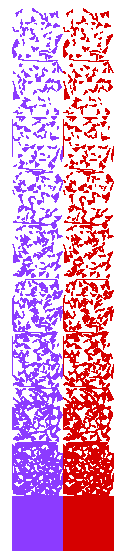

In [32]:
# Produce a shading scale, showing how shading of brain regions corresponds to containment in clusters

from scipy.spatial import Delaunay

n = 300

X = np.random.rand(n, 2)
# X = np.vstack([X, [[0,0],[1,0],[0,1],[1,1]]])

tri = Delaunay(X)
print(f"With {len(X)} points, produced {len(tri.simplices)} triangles")

clusters_to_use = [1, 6]
n_divisions = 10
plt.figure(figsize=(len(clusters_to_use), n_divisions))
for k in reversed(range(n_divisions)):
    if k == 0:
        X = np.vstack([X, [[0,0],[1,0],[0,1],[1,1]]])
        tri = Delaunay(X)
        triangles_to_use = tri.simplices
    else:
        triangles_to_use = tri.simplices[::(k+1)]
    for x, c in enumerate(clusters_to_use):
        plt.tripcolor(X[:,0] + x, X[:,1] + k, triangles=triangles_to_use,
                      facecolors=np.ones(len(triangles_to_use)), cmap=ListedColormap([color_mapper(c, "0.0")]))
#     plt.tripcolor(X[:,0] + 1, X[:,1] + k, triangles=triangles_to_use,
#                   facecolors=np.ones(len(triangles_to_use)), cmap=ListedColormap([color_mapper(6, "0.0")]))
plt.ylim(0,n_divisions)
plt.yticks([])
plt.xticks([])
plt.axis("off")
plt.savefig(os.path.join(figure_dir, "1 Overview Figure", "shading-scale.eps"), bbox_inches="tight")